In [78]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from keras.layers import Dense, LSTM
from sklearn.metrics import mean_absolute_error


In [79]:
df = pd.read_csv('Transaction.csv',sep=';')
df.head()

TransactionID  CustomerID        Date ProductID  Price  Qty  TotalAmount  \
0       TR11369         328  01/01/2022        P3   7500    4        30000   
1       TR16356         165  01/01/2022        P9  10000    7        70000   
2        TR1984         183  01/01/2022        P1   8800    4        35200   
3       TR35256         160  01/01/2022        P1   8800    7        61600   
4       TR41231         386  01/01/2022        P9  10000    1        10000   

   StoreID  
0       12  
1        1  
2        4  
3        4  
4        4

In [80]:
df.isnull().sum()

TransactionID    0
CustomerID       0
Date             0
ProductID        0
Price            0
Qty              0
TotalAmount      0
StoreID          0
dtype: int64

In [81]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5020 entries, 0 to 5019
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   TransactionID  5020 non-null   object
 1   CustomerID     5020 non-null   int64 
 2   Date           5020 non-null   object
 3   ProductID      5020 non-null   object
 4   Price          5020 non-null   int64 
 5   Qty            5020 non-null   int64 
 6   TotalAmount    5020 non-null   int64 
 7   StoreID        5020 non-null   int64 
dtypes: int64(5), object(3)
memory usage: 313.9+ KB


In [82]:
# Change data type
df['Date'] = pd.to_datetime(df['Date'], format='%d/%m/%Y')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5020 entries, 0 to 5019
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   TransactionID  5020 non-null   object        
 1   CustomerID     5020 non-null   int64         
 2   Date           5020 non-null   datetime64[ns]
 3   ProductID      5020 non-null   object        
 4   Price          5020 non-null   int64         
 5   Qty            5020 non-null   int64         
 6   TotalAmount    5020 non-null   int64         
 7   StoreID        5020 non-null   int64         
dtypes: datetime64[ns](1), int64(5), object(2)
memory usage: 313.9+ KB


In [83]:
daily_data = df.groupby('Date')['Qty'].sum()

### Plotting ACF & PACF 

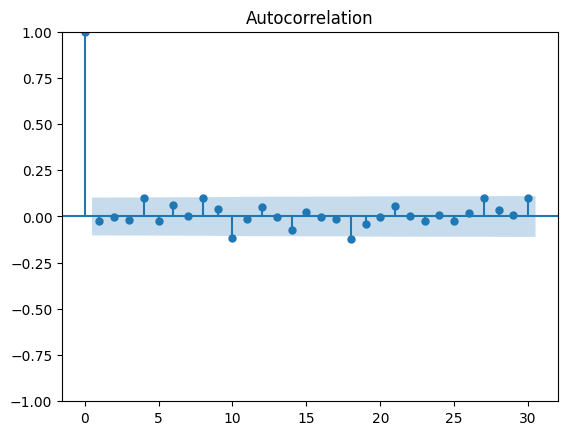

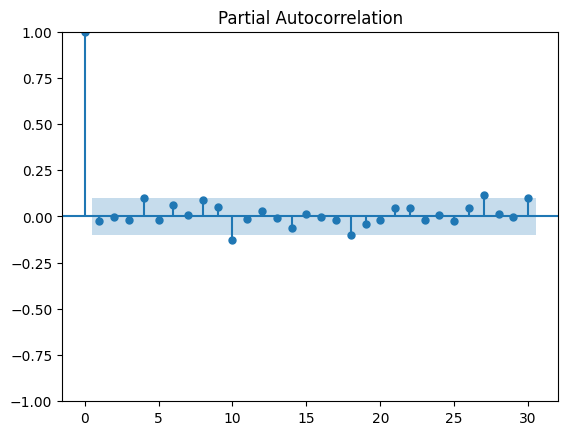

In [84]:
# Plot ACF and PACF to determine AR and MA orders
plot_acf(daily_data, lags=30)
plot_pacf(daily_data, lags=30)
plt.show()

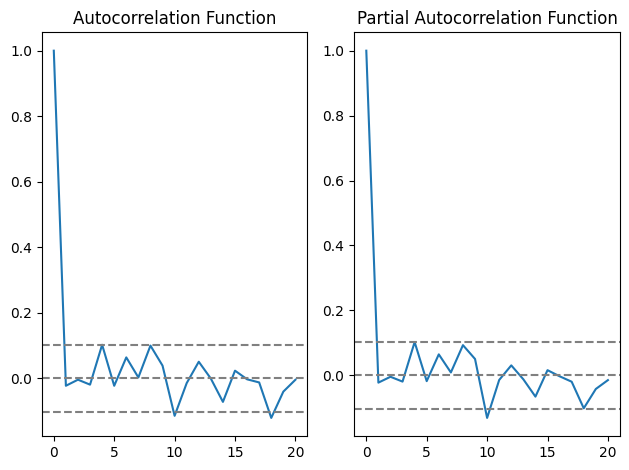

In [85]:
lag_acf = acf(daily_data, nlags=20)
lag_pacf = pacf(daily_data, nlags=20, method='ols')

#Plot ACF:
plt.subplot(121)
plt.plot(lag_acf)
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-1.96/np.sqrt(len(daily_data)), linestyle='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(daily_data)), linestyle='--', color='gray')
plt.title('Autocorrelation Function')            

#Plot PACF
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-1.96/np.sqrt(len(daily_data)), linestyle='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(daily_data)), linestyle='--', color='gray')
plt.title('Partial Autocorrelation Function')
            
plt.tight_layout()  

In [86]:
# p: AR order, d: differencing order, q: MA order
p = 2  # You can adjust this based on the ACF plot
d = 1  # You determined the need for differencing
q = 1  # You can adjust this based on the PACF plot

model = ARIMA(daily_data, order=(p, d, q))
model_fit = model.fit()

c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


### Building Models 

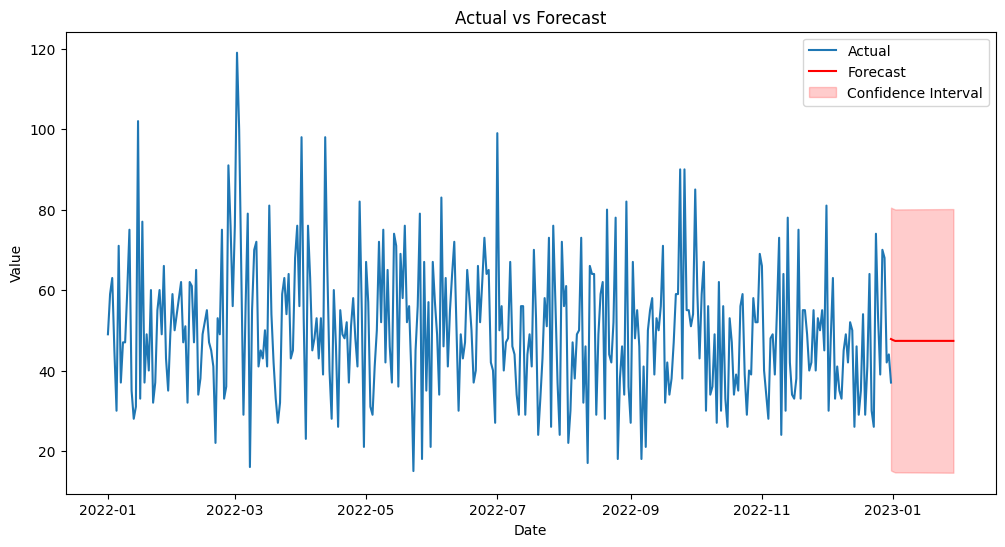

In [87]:
# Melakukan ramalan
forecast_steps = 30  # Jumlah langkah ke depan untuk meramalkan
forecast = model_fit.get_forecast(steps=forecast_steps).predicted_mean
conf_int = model_fit.get_forecast(steps=forecast_steps).conf_int()

# Menampilkan hasil ramalan
plt.figure(figsize=(12, 6))
plt.plot(daily_data, label='Actual')
plt.plot(pd.date_range(start=daily_data.index[-1], periods=forecast_steps, freq=daily_data.index.inferred_freq), forecast, label='Forecast', color='red')
plt.fill_between(pd.date_range(start=daily_data.index[-1], periods=forecast_steps, freq=daily_data.index.inferred_freq), conf_int.iloc[:, 0], conf_int.iloc[:, 1], color='r', alpha=0.2, label='Confidence Interval')
plt.title('Actual vs Forecast')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.show()

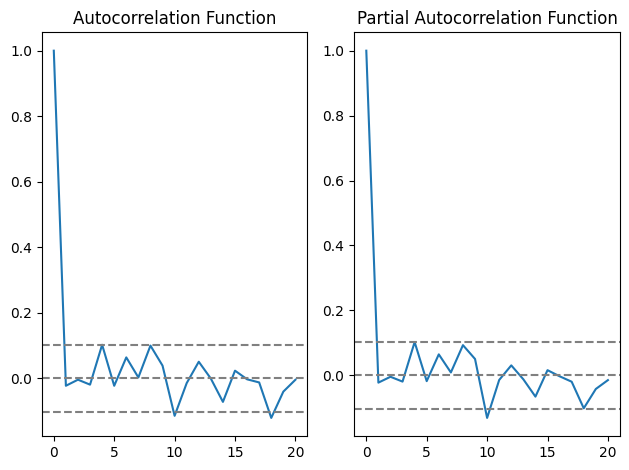

In [88]:
lag_acf = acf(daily_data, nlags=20)
lag_pacf = pacf(daily_data, nlags=20, method='ols')

#Plot ACF:
plt.subplot(121)
plt.plot(lag_acf)
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-1.96/np.sqrt(len(daily_data)), linestyle='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(daily_data)), linestyle='--', color='gray')
plt.title('Autocorrelation Function')            

#Plot PACF
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-1.96/np.sqrt(len(daily_data)), linestyle='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(daily_data)), linestyle='--', color='gray')
plt.title('Partial Autocorrelation Function')
            
plt.tight_layout()            

In [89]:
# Menghitung Mean Absolute Error (MAE)
actual_values = daily_data[-forecast_steps:]  # Mengambil data aktual yang sesuai dengan langkah-langkah ramalan
mae = mean_absolute_error(actual_values, forecast)

print("Mean Absolute Error (MAE):", mae)

Mean Absolute Error (MAE): 11.37298830705372
